In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from graphviz import Digraph
def trace(root): # using dfs to build a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes: # only add each node once
            nodes.add(v)
            for child in v._prev: # traverse each child only once
                edges.add((child, v)) # from child to parent
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR means left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{%s | %s | data %.2f | grad %.2f}" % (n._op, n.label, n.data, n.grad), shape='record')
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)))
    return dot

In [4]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # default: no action for leaf nodes
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # for printing
        return f"Value(data={self.data})"

    def __add__(self, other): # a + b
        other = other if isinstance(other, Value) else Value(other) # support cases like "a + 2"
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out

    def __neg__(self): # -a
        return self * -1
    
    def __sub__(self, other): # a - b
        return self + (-other)

    def __mul__(self, other): # a * b
        other = other if isinstance(other, Value) else Value(other) # support cases like "a * 2"
        out = Value(self.data * other.data, (self, other), '*')
        def _backward(): # set self.grad and other.grad based on out.grad
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __radd__(self, other): # support cases like "2 + a"
        return self + other

    def __rmul__(self, other): # support cases like "2 * a"
        return self * other

    def __pow__(self, other): # support cases like "a ** 2"
        assert isinstance(other, int) or isinstance(other, float), "Exponent must be int or float"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += out.grad * other * (self.data**(other-1))
        out._backward = _backward
        return out

    def __truediv__(self, other): # support cases like "a / 2"
        return self * other**-1

    def __rtruediv__(self, other): # support cases like "2 / a"
        return other / self

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - t**2)
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

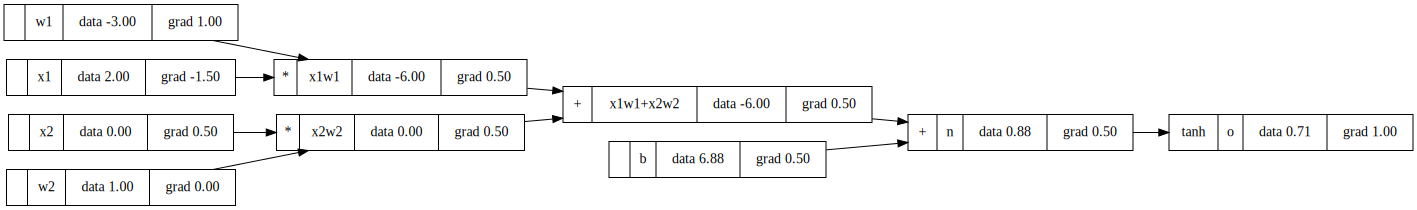

In [19]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
xw_sum = x1w1 + x2w2; xw_sum.label = 'x1w1+x2w2'
n = xw_sum + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1.0
o.label = 'o'
o.backward()
draw_dot(o)

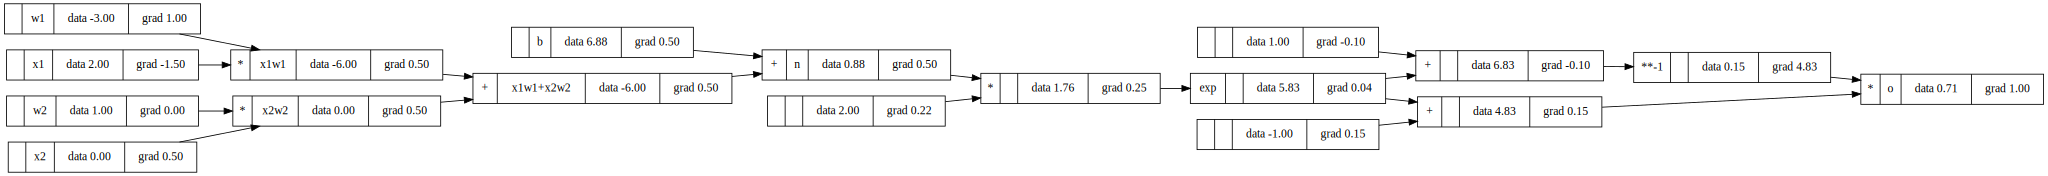

In [20]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
xw_sum = x1w1 + x2w2; xw_sum.label = 'x1w1+x2w2'
n = xw_sum + b; n.label = 'n'
e = (n*2).exp()
o = (e - 1) / (e + 1)

o.grad = 1.0
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import random 
class Neuron:
    def __init__(self, nin): # nin: number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # the 2nd (optional)arg is the start number, which is b
        out = activation.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts): # now we have multiple "number of outs"
        sz = [nin] + nouts # nin as the first element
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
xs = [
    [2.0, 3.0, 1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

nouts = [4, 4, 1]
mlp = MLP(3, nouts)
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.7706781698377059),
 Value(data=0.815649506864868),
 Value(data=0.4519276430066956),
 Value(data=0.7990390060985371)]

In [13]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

[Value(data=0.052588501788984075),
 Value(data=3.2965831317786383),
 Value(data=2.1080938805269787),
 Value(data=0.040385321069863825)]